In [4]:
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
from Utility import *
import importlib
from concurrent.futures import ThreadPoolExecutor
import matplotlib
import seaborn as sns
%matplotlib inline

In [5]:
raw_json = json.load(open('test_results.json'))

In [7]:
def exp_name_parser(exp_name):
    exp_name = exp_name.split('_')
    return {
        "size": [int(i) for i in (exp_name[0].split('x'))],
        "num_agents": int(exp_name[1][6:]),
        "cost_multiplier": float(exp_name[2][5:]),
        "rep_num": int(exp_name[3][3:])
    }

In [8]:
exp_names= list(raw_json.keys())

In [9]:
exp_name_parser(exp_names[0])

{'size': [4, 4], 'num_agents': 5, 'cost_multiplier': 50.0, 'rep_num': 0}

In [10]:
raw_json[exp_names[0]]

{'graph': {'seed_value': 13,
  'n_rows': 4,
  'n_cols': 4,
  'nodes': [{'id': 0, 'pos': [0, 0]},
   {'id': 1, 'pos': [1, 0]},
   {'id': 2, 'pos': [2, 0]},
   {'id': 3, 'pos': [3, 0]},
   {'id': 4, 'pos': [0, -1]},
   {'id': 5, 'pos': [1, -1]},
   {'id': 6, 'pos': [2, -1]},
   {'id': 7, 'pos': [3, -1]},
   {'id': 8, 'pos': [0, -2]},
   {'id': 9, 'pos': [1, -2]},
   {'id': 10, 'pos': [2, -2]},
   {'id': 11, 'pos': [3, -2]},
   {'id': 12, 'pos': [0, -3]},
   {'id': 13, 'pos': [1, -3]},
   {'id': 14, 'pos': [2, -3]},
   {'id': 15, 'pos': [3, -3]}],
  'edges': [{'source': 0,
    'target': 1,
    'base_cost': 37.410319718581476,
    'actual_cost': 37.410319718581476},
   {'source': 0,
    'target': 4,
    'base_cost': 43.973446455597205,
    'actual_cost': 43.973446455597205},
   {'source': 1,
    'target': 2,
    'base_cost': 19.222344358618724,
    'actual_cost': 961.1172179309361},
   {'source': 1,
    'target': 5,
    'base_cost': 19.006517422484507,
    'actual_cost': 19.006517422484507

In [11]:
def parse_exp(exp_name):
    
    exp = raw_json[exp_name]
    exp_stats = exp_name_parser(exp_name)
    
    graph=nx.Graph()
   
    nodes= exp["graph"]["nodes"]
    for node in nodes:
        
        graph.add_node(node["id"], pos=node["pos"])
    
    edge_datas = exp["graph"]["edges"]
    
    for edge_data in edge_datas:
        u = edge_data["source"]
        v = edge_data["target"]
        base_cost = edge_data["base_cost"]
        actual_cost = edge_data["actual_cost"]
        
        graph.add_edge(u, v, base_cost=base_cost, actual_cost=actual_cost)
        graph.add_edge(v, u, base_cost=base_cost, actual_cost=actual_cost)
    
    
    def route_cost(route):
        cost = 0
        for i in range(len(route)-1):
            cost += graph[route[i]][route[i+1]]["actual_cost"]
        return cost
    
    def base_weight(u, v, d):
        return graph[u][v]["base_cost"]
    
    true_path = nx.dijkstra_path(graph, 0, graph.number_of_nodes()-1, weight="actual_cost")
    true_path_cost = route_cost(true_path)
    
    blind_path = nx.dijkstra_path(graph, 0, graph.number_of_nodes()-1, weight="base_cost")
    blind_path_cost = route_cost(blind_path)
    
    
    
    exp_alg = exp["algorithm"]
    
    n_route_change=exp_alg["n_route_change"]
    
    
    agent_data = []
    
    for agent in exp_alg["agents"]:
        agent["path_cost"] =route_cost([x[0] for x in agent["route"]])
        agent_path = [x[0] for x in agent["route"]]
        
        heuristic_map = {}
        
        for k,v in agent["heuristic_map"].items():
            edge = ast.literal_eval(k)
            heuristic_map[(edge[0], edge[1])] =v
            
    
        
        def heuristic_weight(u, v, d):
            return heuristic_map[(u,v)]
        
        heuristic_route = nx.dijkstra_path(graph, 0, graph.number_of_nodes()-1, weight=heuristic_weight)
        heuristic_cost = route_cost(heuristic_route)
        
        agent_data.append({
            "id": agent["agent_id"],
            "path": agent_path,
            "path_cost": agent["path_cost"],
            "heuristic_cost": heuristic_cost,
            "heuristic_path": heuristic_route
        })
        
        
        
    return {
        "name": exp_name,
        "exp_params": exp_stats,
        "graph": graph,
        "blind_path": blind_path,
        "blind_path_cost": blind_path_cost,
        "true_path": true_path,
        "true_path_cost": true_path_cost,
        "n_route_change": n_route_change,
        "agent_data": agent_data
    }

    

In [12]:
with ThreadPoolExecutor() as executor:
    exp_data = executor.map(parse_exp, exp_names)
    
exp_data = list(exp_data)

In [15]:
import pickle

with open('clean_data.pkl', 'wb') as f:
    
    pickle.dump(exp_data, f)
    


In [14]:
import pickle
exp_data= pickle.load(open('clean_data.pkl', 'rb'))

In [ ]:
"""
- 'agent_data': Her bir ajanın heuristic'i ile bulduğu ve algoritma ile bulduğu rotaları içerir.
 Her ajanda:
      * 'id': Ajanın kimliği
      * 'path': Ajanın gerçekte izlediği node listesi
      * 'path_cost': Ajanın algoritma sonucu gerçek yol maliyeti
      * 'heuristic_path': Heuristik  yolla bulunan nodelar
      * 'heuristic_cost': Heuristik yönteme göre hesaplanan yaklaşık maliyet

- 'blind_path' ve 'blind_path_cost': Deprem olmamış gibi davranıldığında
   elde edilmiş yol ve onun toplam maliyeti

- 'exp_params': Deney parametrelerini içerir:
      * 'cost_multiplier': Maliyet çarpanı
      * 'num_agents': Kaç tane ajan olduğu
      * 'rep_num': Deney tekrarı (repetition) indeksi aynı parameterlerle yapılan deneyin kaçıncı tekrarı olduğu)
      * 'size': Manhattan grid'in boyutu (x,y)

- 'graph': NetworkX kütüphanesi kullanılarak oluşturulmuş bir grafik (Graph) objesi
- 'name': Deneyin veya senaryonun ismi
- 'true_path' ve 'true_path_cost': Gerçek (en iyi veya hedef) yol ve bunun maliyeti

Bu sözlük yapısı, hem farklı algoritmaların veya yöntemlerin ürettiği yolların karşılaştırmasını
hem de deneyin tekrar edilebilir parametrelerini barındırır. Her bir alan, farklı bir algoritma
veya ajanın nasıl performans gösterdiğini analiz etmede kullanılabilir.
"""
print()

In [6]:
"""
Measures to be calculated:
- First reach cost/true path cost
- First reach cost/heuristic path cost
- First reach cost/blind path cost

- Average path cost/true path cost
- Average path cost/heuristic path cost
- Average path cost/blind path cost

- Number of changes in the route
- Number of changes in the route/number of agents
- Number of changes in the route/number of nodes

"""

'\nMeasures to be calculated:\n- First reach cost/true path cost\n- First reach cost/heuristic path cost\n- First reach cost/blind path cost\n\n- Average path cost/true path cost\n- Average path cost/heuristic path cost\n- Average path cost/blind path cost\n\n- Number of changes in the route\n- Number of changes in the route/number of agents\n- Number of changes in the route/number of nodes\n\n'

In [16]:

measures = []

for data in exp_data:
    exp_params = data["exp_params"]
    true_path_cost = data["true_path_cost"]
    blind_path_cost = data["blind_path_cost"]
    
    for agent in data["agent_data"]:
        measures.append({
            "exp_name": data["name"],
            "agent_id": agent["id"],
            "true_path": data["true_path"],
            "true_path_cost": true_path_cost,
            "blind_path": data["blind_path"],
            "blind_path_cost": blind_path_cost,
            "path": agent["path"],
            "path_cost": agent["path_cost"],
            "heuristic_cost": agent["heuristic_cost"],
            "n_route_change": data["n_route_change"],
            "num_agents": exp_params["num_agents"],
            "size": exp_params["size"]
            
        })
    

In [17]:
measures_df = pd.DataFrame(measures)

In [18]:
measures_df[measures_df["heuristic_cost"]<measures_df["true_path_cost"]]

,exp_name,agent_id,true_path,true_path_cost,blind_path,blind_path_cost,path,path_cost,heuristic_cost,n_route_change,num_agents,size


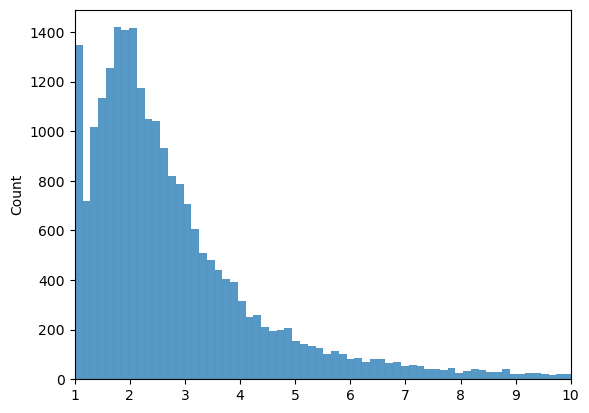

In [19]:
sns.histplot((measures_df["path_cost"]/measures_df["true_path_cost"]))
plt.xlim(1, 10)
plt.show()

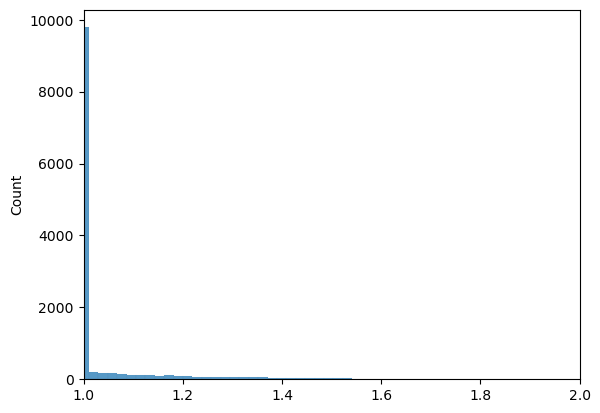

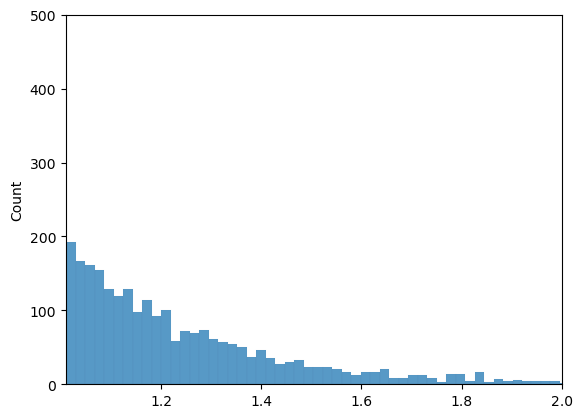

In [18]:
sns.histplot((measures_df["path_cost"]/measures_df["heuristic_cost"]))
plt.xlim(1, 2)
plt.show()
sns.histplot((measures_df["path_cost"]/measures_df["heuristic_cost"]))
plt.xlim(1.01, 2)
plt.ylim(0, 500)
plt.show()

In [19]:
measures_df["path_perc"]=measures_df["path_cost"]/measures_df["true_path_cost"]

In [20]:
measures_df["n_nodes"]=measures_df["size"].apply(lambda x: x[0]*x[1])

In [24]:
measures_df = measures_df[measures_df["size"]==(10,10)]

In [62]:
measures_df.head()

,exp_name,agent_id,true_path,true_path_cost,blind_path,blind_path_cost,path,path_cost,heuristic_cost,n_route_change,num_agents,size
0,4x4_agents5_cmult50_rep0,4,"[0, 1, 2, 3, 7, 11, 15]",3081.819815,"[0, 1, 5, 9, 13, 14, 15]",4581.859013,"[0, 1, 2, 3, 7, 11, 15]",3081.819815,3081.819815,36,5,"[4, 4]"
1,4x4_agents5_cmult50_rep0,3,"[0, 1, 2, 3, 7, 11, 15]",3081.819815,"[0, 1, 5, 9, 13, 14, 15]",4581.859013,"[0, 1, 5, 4, 8, 12, 13, 14, 15]",3906.668650,3906.668650,36,5,"[4, 4]"
2,4x4_agents5_cmult50_rep0,1,"[0, 1, 2, 3, 7, 11, 15]",3081.819815,"[0, 1, 5, 9, 13, 14, 15]",4581.859013,"[0, 1, 5, 1, 0, 4, 8, 9, 13, 14, 15]",4601.196798,4535.142600,36,5,"[4, 4]"
3,4x4_agents5_cmult50_rep0,2,"[0, 1, 2, 3, 7, 11, 15]",3081.819815,"[0, 1, 5, 9, 13, 14, 15]",4581.859013,"[0, 1, 2, 6, 7, 11, 15]",5956.663448,5956.663448,36,5,"[4, 4]"
4,4x4_agents5_cmult50_rep0,0,"[0, 1, 2, 3, 7, 11, 15]",3081.819815,"[0, 1, 5, 9, 13, 14, 15]",4581.859013,"[0, 4, 8, 9, 10, 11, 15]",6195.547771,6195.547771,36,5,"[4, 4]"


In [23]:
measures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   exp_name         25000 non-null  object 
 1   agent_id         25000 non-null  int64  
 2   true_path        25000 non-null  object 
 3   true_path_cost   25000 non-null  float64
 4   blind_path       25000 non-null  object 
 5   blind_path_cost  25000 non-null  float64
 6   path             25000 non-null  object 
 7   path_cost        25000 non-null  float64
 8   heuristic_cost   25000 non-null  float64
 9   n_route_change   25000 non-null  int64  
 10  num_agents       25000 non-null  int64  
 11  size             25000 non-null  object 
 12  path_perc        25000 non-null  float64
 13  n_nodes          25000 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 2.7+ MB


In [21]:
def first_to_reach(df):
    first_agent = df.loc[df["path_cost"].idxmin()]
    
    return pd.Series({
        "first_agent_id": first_agent["agent_id"],
        "first_agent_path_cost": first_agent["path_cost"],
        "first_agent_true_cost": first_agent["true_path_cost"],
        "first_agent_heuristic_cost": first_agent["heuristic_cost"],
        "first_agent_blind_cost": first_agent["blind_path_cost"],
        "path_cost_to_true_ratio": first_agent["path_cost"] / first_agent["true_path_cost"],
        "path_cost_to_heuristic_ratio": first_agent["path_cost"] / first_agent["heuristic_cost"],
        "path_cost_to_blind_ratio": first_agent["path_cost"] / first_agent["blind_path_cost"],
    })

def last_to_reach(df):
    last_agent = df.loc[df["path_cost"].idxmax()]
    
    return pd.Series({
        "last_agent_id": last_agent["agent_id"],
        "last_agent_path_cost": last_agent["path_cost"],
        "last_agent_true_cost": last_agent["true_path_cost"],
        "last_agent_heuristic_cost": last_agent["heuristic_cost"],
        "last_agent_blind_cost": last_agent["blind_path_cost"],
        "path_cost_to_true_ratio": last_agent["path_cost"] / last_agent["true_path_cost"],
        "path_cost_to_heuristic_ratio": last_agent["path_cost"] / last_agent["heuristic_cost"],
        "path_cost_to_blind_ratio": last_agent["path_cost"] / last_agent["blind_path_cost"],
    })
    
def average_agent(df):
    return pd.Series({
        "average_path_cost": df["path_cost"].mean(),
        "average_true_cost": df["true_path_cost"].mean(),
        "average_heuristic_cost": df["heuristic_cost"].mean(),
        "average_blind_cost": df["blind_path_cost"].mean(),
        "path_cost_to_true_ratio": df["path_cost"].mean() / df["true_path_cost"].mean(),
        "path_cost_to_heuristic_ratio": df["path_cost"].mean() / df["heuristic_cost"].mean(),
        "path_cost_to_blind_ratio": df["path_cost"].mean() / df["blind_path_cost"].mean(),
    })

def route_changes(df):
    return pd.Series({
        "number_of_agents" : df["num_agents"].mean(),
        "number_of_route_changes": df["n_route_change"].mean(),
        "route_change_to_agent_ratio": df["n_route_change"].mean()/df["num_agents"].mean(),
    })

In [22]:
first_agent_results = []
last_agent_results = []
average_agent_results = []
route_change_results = []

experiment_names = measures_df["exp_name"].unique()

for exp_name in experiment_names:
    exp_data = measures_df[measures_df["exp_name"] == exp_name]
    
    # store results in a dictionary
    first_agent_results.append(first_to_reach(exp_data))
    last_agent_results.append(last_to_reach(exp_data))
    average_agent_results.append(average_agent(exp_data))
    route_change_results.append(route_changes(exp_data))
    

first_agent_results = pd.DataFrame(first_agent_results)
last_agent_results = pd.DataFrame(last_agent_results)
average_agent_results = pd.DataFrame(average_agent_results)
route_change_results = pd.DataFrame(route_change_results)


In [114]:
first_agent_results.head()

,first_agent_id,first_agent_path_cost,first_agent_true_cost,first_agent_heuristic_cost,first_agent_blind_cost,path_cost_to_true_ratio,path_cost_to_heuristic_ratio,path_cost_to_blind_ratio
0,4.0,3081.819815,3081.819815,3081.819815,4581.859013,1.000000,1.0,0.672613
1,0.0,2679.728530,803.363588,2679.728530,2679.728530,3.335636,1.0,1.000000
2,3.0,2144.491752,2144.491752,2144.491752,2144.491752,1.000000,1.0,1.000000
3,2.0,2300.943961,2229.242635,2300.943961,4550.347316,1.032164,1.0,0.505663
4,2.0,2833.798651,2833.798651,2833.798651,4519.102689,1.000000,1.0,0.627071


In [90]:
first_agent_results["path_cost_to_heuristic_ratio"].mean()

np.float64(0.9168691937717363)

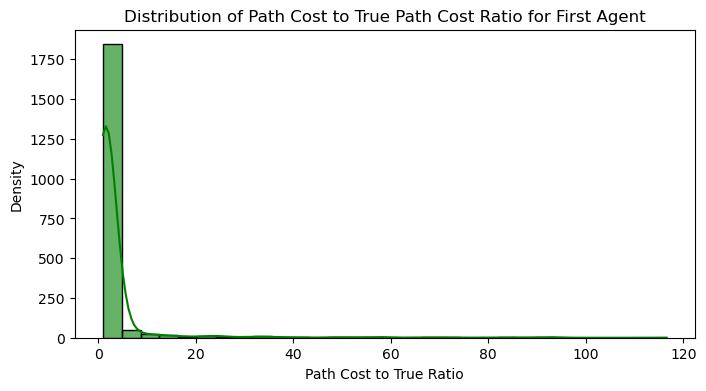

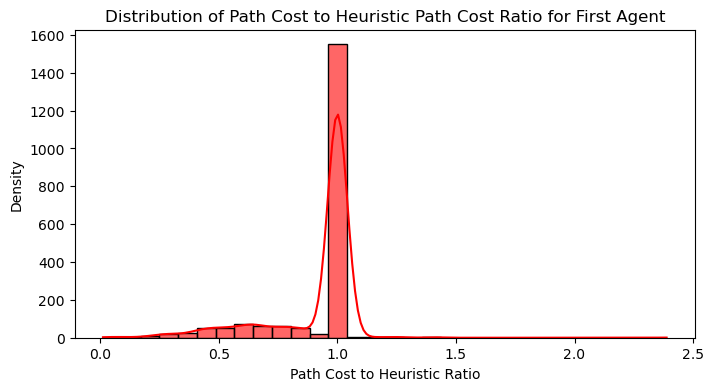

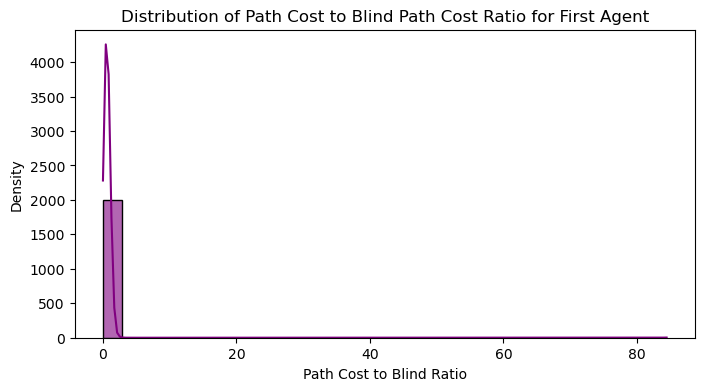

In [98]:
# Plot distribution of path cost to true ratio
plt.figure(figsize=(8, 4))
sns.histplot(first_agent_results["path_cost_to_true_ratio"], kde=True, bins=30, color='green', alpha=0.6)
plt.xlabel("Path Cost to True Ratio")
plt.ylabel("Density")
plt.title("Distribution of Path Cost to True Path Cost Ratio for First Agent")
plt.show()

# Plot distribution of path cost to heuristic ratio
plt.figure(figsize=(8, 4))
sns.histplot(first_agent_results["path_cost_to_heuristic_ratio"], kde=True, bins=30, color='red', alpha=0.6)
plt.xlabel("Path Cost to Heuristic Ratio")
plt.ylabel("Density")
plt.title("Distribution of Path Cost to Heuristic Path Cost Ratio for First Agent")
plt.show()

# Plot distribution of path cost to blind ratio
plt.figure(figsize=(8, 4))
sns.histplot(first_agent_results["path_cost_to_blind_ratio"], kde=True, bins=30, color='purple', alpha=0.6)
plt.xlabel("Path Cost to Blind Ratio")
plt.ylabel("Density")
plt.title("Distribution of Path Cost to Blind Path Cost Ratio for First Agent")
plt.show()

In [79]:
last_agent_results.head()

,last_agent_id,last_agent_path_cost,last_agent_true_cost,last_agent_heuristic_cost,last_agent_blind_cost,path_cost_to_true_ratio,path_cost_to_heuristic_ratio,path_cost_to_blind_ratio
0,0.0,6195.547771,3081.819815,6195.547771,4581.859013,2.010354,1.000000,1.352191
1,2.0,5916.707633,803.363588,5916.707633,2679.728530,7.364919,1.000000,2.207950
2,4.0,3910.684494,2144.491752,3910.684494,2144.491752,1.823595,1.000000,1.823595
3,0.0,6921.164381,2229.242635,8882.064275,4550.347316,3.104716,0.779229,1.521019
4,0.0,4052.341271,2833.798651,4052.341271,4519.102689,1.430003,1.000000,0.896714


In [80]:
last_agent_results["path_cost_to_heuristic_ratio"].mean()

np.float64(1.0252860605921668)

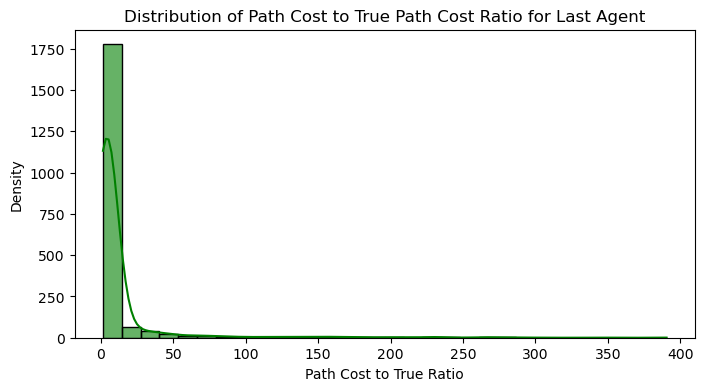

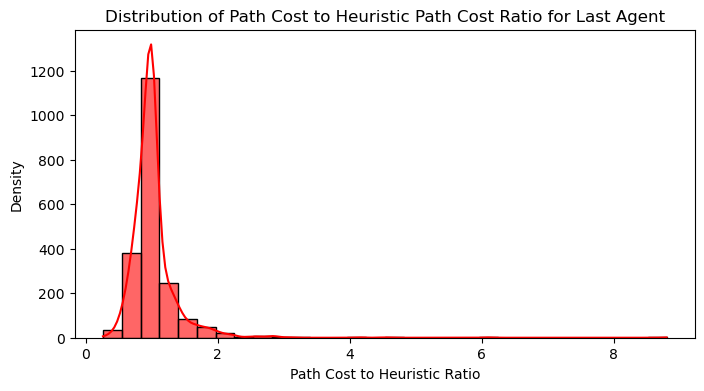

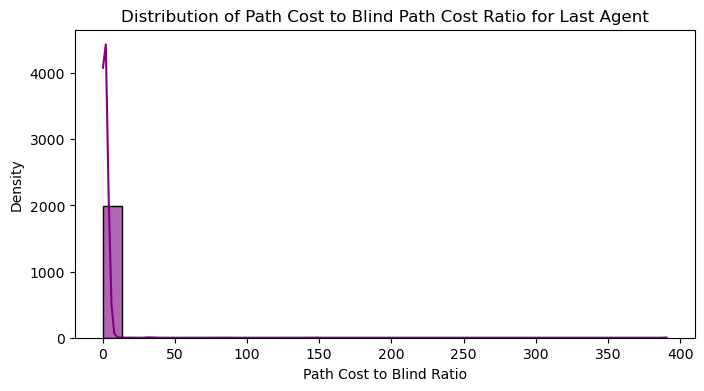

In [99]:
# Plot distribution of path cost to true ratio
plt.figure(figsize=(8, 4))
sns.histplot(last_agent_results["path_cost_to_true_ratio"], kde=True, bins=30, color='green', alpha=0.6)
plt.xlabel("Path Cost to True Ratio")
plt.ylabel("Density")
plt.title("Distribution of Path Cost to True Path Cost Ratio for Last Agent")
plt.show()

# Plot distribution of path cost to heuristic ratio
plt.figure(figsize=(8, 4))
sns.histplot(last_agent_results["path_cost_to_heuristic_ratio"], kde=True, bins=30, color='red', alpha=0.6)
plt.xlabel("Path Cost to Heuristic Ratio")
plt.ylabel("Density")
plt.title("Distribution of Path Cost to Heuristic Path Cost Ratio for Last Agent")
plt.show()

# Plot distribution of path cost to blind ratio
plt.figure(figsize=(8, 4))
sns.histplot(last_agent_results["path_cost_to_blind_ratio"], kde=True, bins=30, color='purple', alpha=0.6)
plt.xlabel("Path Cost to Blind Ratio")
plt.ylabel("Density")
plt.title("Distribution of Path Cost to Blind Path Cost Ratio for Last Agent")
plt.show()

In [115]:
average_agent_results.head()

,average_path_cost,average_true_cost,average_heuristic_cost,average_blind_cost,path_cost_to_true_ratio,path_cost_to_heuristic_ratio,path_cost_to_blind_ratio
0,4748.379296,3081.819815,4735.168457,4581.859013,1.540771,1.002790,1.036343
1,3766.401126,803.363588,3766.401126,2679.728530,4.688290,1.000000,1.405516
2,3235.504623,2144.491752,3235.504623,2144.491752,1.508751,1.000000,1.508751
3,4346.825386,2229.242635,5026.791078,4550.347316,1.949911,0.864732,0.955273
4,3505.979392,2833.798651,3505.979392,4519.102689,1.237201,1.000000,0.775813


In [116]:
average_agent_results["path_cost_to_heuristic_ratio"].mean()

np.float64(0.8484093339024216)

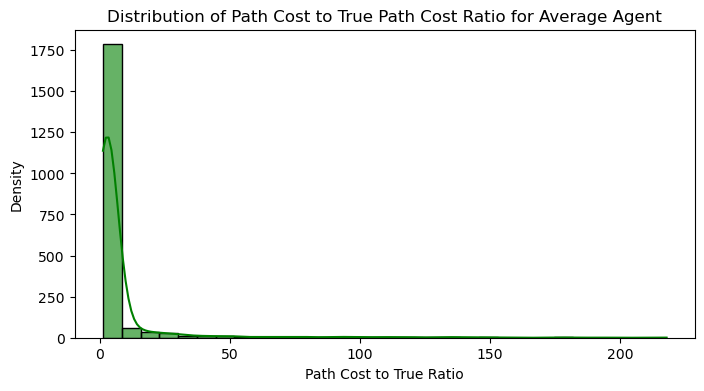

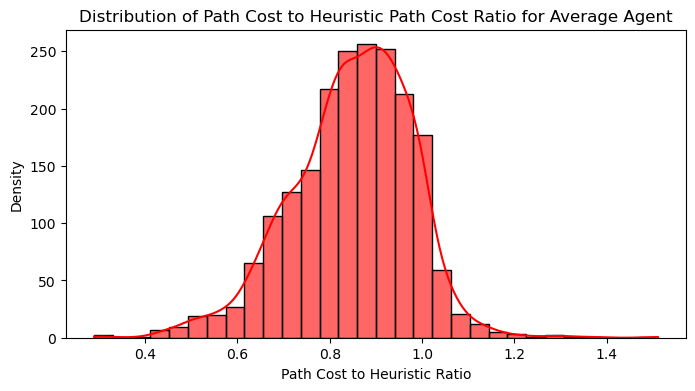

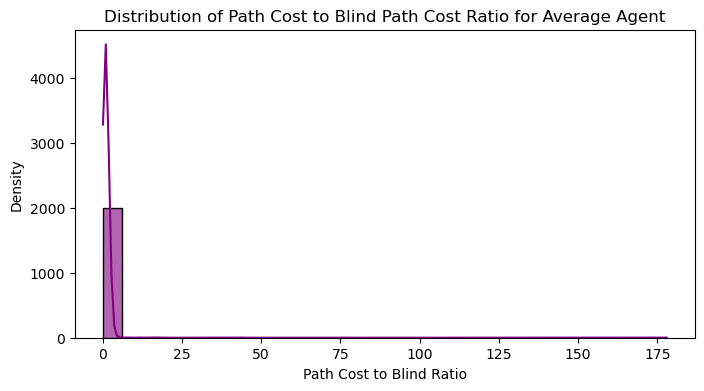

In [118]:
# Plot distribution of path cost to true ratio
plt.figure(figsize=(8, 4))
sns.histplot(average_agent_results["path_cost_to_true_ratio"], kde=True, bins=30, color='green', alpha=0.6)
plt.xlabel("Path Cost to True Ratio")
plt.ylabel("Density")
plt.title("Distribution of Path Cost to True Path Cost Ratio for Average Agent")
plt.show()

# Plot distribution of path cost to heuristic ratio
plt.figure(figsize=(8, 4))
sns.histplot(average_agent_results["path_cost_to_heuristic_ratio"], kde=True, bins=30, color='red', alpha=0.6)
plt.xlabel("Path Cost to Heuristic Ratio")
plt.ylabel("Density")
plt.title("Distribution of Path Cost to Heuristic Path Cost Ratio for Average Agent")
plt.show()

# Plot distribution of path cost to blind ratio
plt.figure(figsize=(8, 4))
sns.histplot(average_agent_results["path_cost_to_blind_ratio"], kde=True, bins=30, color='purple', alpha=0.6)
plt.xlabel("Path Cost to Blind Ratio")
plt.ylabel("Density")
plt.title("Distribution of Path Cost to Blind Path Cost Ratio for Average Agent")
plt.show()

In [85]:
route_change_results.head()

,number_of_agents,number_of_route_changes,route_change_to_agent_ratio
0,5.0,36.0,7.2
1,5.0,32.0,6.4
2,5.0,32.0,6.4
3,5.0,34.0,6.8
4,5.0,30.0,6.0


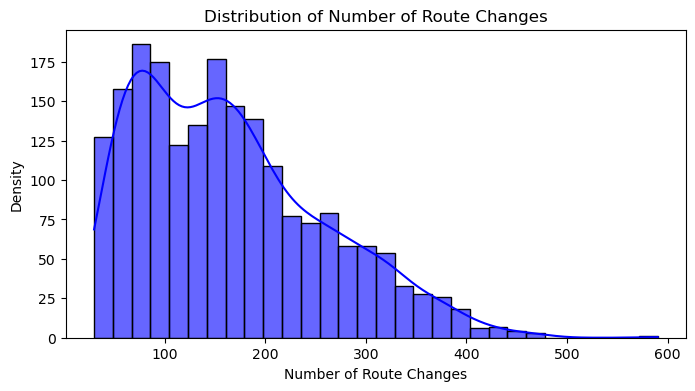

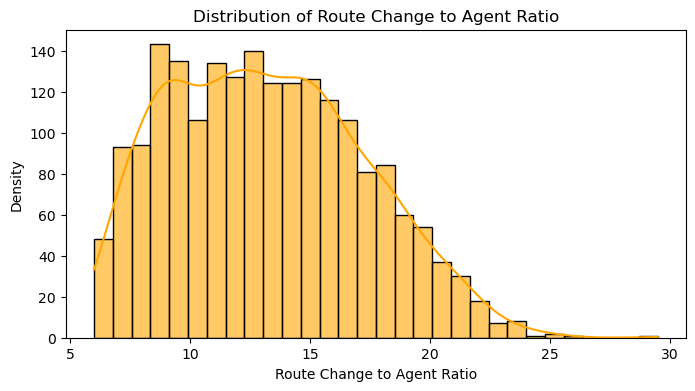

In [119]:
# Plot distribution of number of route changes
plt.figure(figsize=(8, 4))
sns.histplot(route_change_results["number_of_route_changes"], kde=True, bins=30, color='blue', alpha=0.6)
plt.xlabel("Number of Route Changes")
plt.ylabel("Density")
plt.title("Distribution of Number of Route Changes")
plt.show()

# Plot distribution of route change to agent ratio
plt.figure(figsize=(8, 4))
sns.histplot(route_change_results["route_change_to_agent_ratio"], kde=True, bins=30, color='orange', alpha=0.6)
plt.xlabel("Route Change to Agent Ratio")
plt.ylabel("Density")
plt.title("Distribution of Route Change to Agent Ratio")
plt.show()

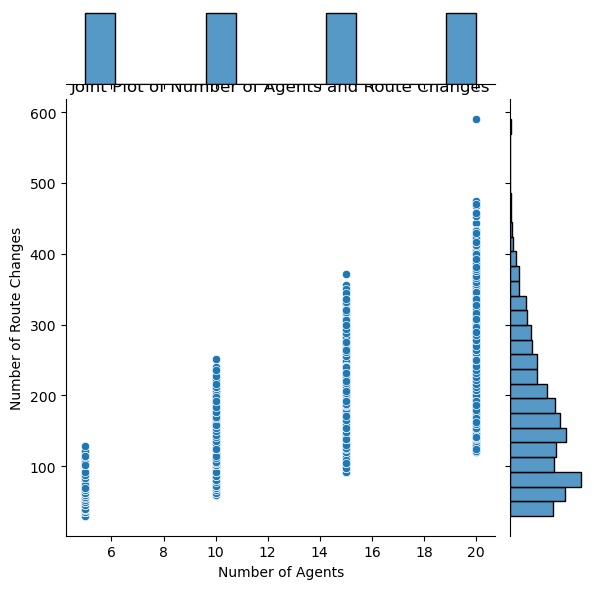

In [120]:
sns.jointplot(x='number_of_agents', y='number_of_route_changes', data=route_change_results, kind='scatter')
plt.xlabel("Number of Agents")
plt.ylabel("Number of Route Changes")
plt.title("Joint Plot of Number of Agents and Route Changes")
plt.show()

In [34]:
def average_agent(df):
    return pd.Series({
        
        "number_of_agents" : df["num_agents"].mean(),
        "average_path_cost": df["path_cost"].mean(),
        "average_true_cost": df["true_path_cost"].mean(),
        "average_heuristic_cost": df["heuristic_cost"].mean(),
        "average_blind_cost": df["blind_path_cost"].mean(),
        "path_cost_to_true_ratio": df["path_cost"].mean() / df["true_path_cost"].mean(),
        "path_cost_to_heuristic_ratio": df["path_cost"].mean() / df["heuristic_cost"].mean(),
        "path_cost_to_blind_ratio": df["path_cost"].mean() / df["blind_path_cost"].mean(),
    })

In [56]:
df_analysis = []
experiment_names = measures_df["exp_name"].unique()

for exp_name in experiment_names:
    exp_data = measures_df[measures_df["exp_name"] == exp_name]
    exp_size = exp_data["size"].iloc[0]
    dataset = average_agent(exp_data)
    dataset["size"] = exp_size
    df_analysis.append(dataset)
    
df_analysis = pd.DataFrame(df_analysis)
df_analysis.head()
    

,number_of_agents,average_path_cost,average_true_cost,average_heuristic_cost,average_blind_cost,path_cost_to_true_ratio,path_cost_to_heuristic_ratio,path_cost_to_blind_ratio,size
0,5.0,4748.379296,3081.819815,4735.168457,4581.859013,1.540771,1.002790,1.036343,"[4, 4]"
1,5.0,3766.401126,803.363588,3766.401126,2679.728530,4.688290,1.000000,1.405516,"[4, 4]"
2,5.0,3235.504623,2144.491752,3235.504623,2144.491752,1.508751,1.000000,1.508751,"[4, 4]"
3,5.0,4346.825386,2229.242635,5026.791078,4550.347316,1.949911,0.864732,0.955273,"[4, 4]"
4,5.0,3505.979392,2833.798651,3505.979392,4519.102689,1.237201,1.000000,0.775813,"[4, 4]"


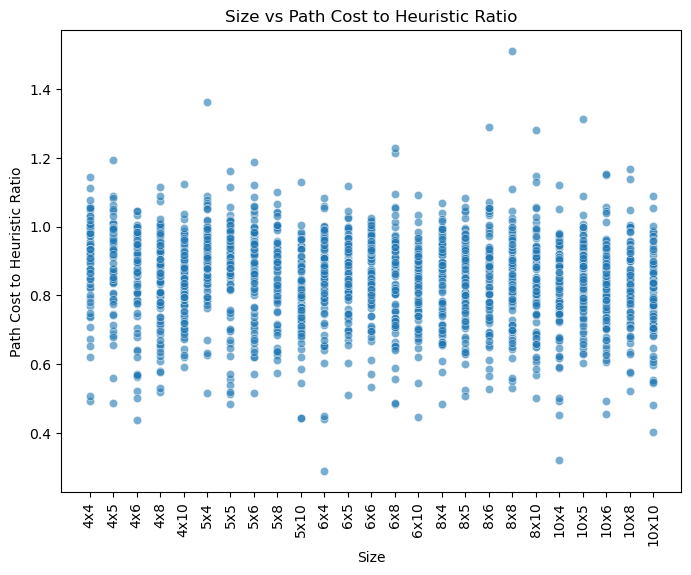

In [57]:
df_analysis['size'] = df_analysis['size'].apply(lambda x: f"{x[0]}x{x[1]}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='size', y='path_cost_to_heuristic_ratio', data=df_analysis, alpha=0.6)
plt.xlabel("Size")
plt.ylabel("Path Cost to Heuristic Ratio")
plt.title("Size vs Path Cost to Heuristic Ratio")
plt.xticks(rotation=90)
plt.show()